In [1]:
!pip install pandasql

In [2]:
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import pandas as pd
import pandasql as ps
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("churn-bigml-80.csv")

In [4]:
df["Churn_int"] = df["Churn"].astype(int)

In [9]:
df["Churn_int"].value_counts()

Churn_int
0    2278
1     388
Name: count, dtype: int64

In [12]:
variables_utiles = [
    'Account length', 'Total day minutes', 'Total eve minutes', 
    'Total night minutes','Total intl charge', 'Customer service calls',
    'International plan', 'Churn_int'
]

In [14]:
df_modelo = df[variables_utiles]
df_modelo.dtypes

Account length              int64
Total day minutes         float64
Total eve minutes         float64
Total night minutes       float64
Total intl charge         float64
Customer service calls      int64
International plan         object
Churn_int                   int32
dtype: object

## ML / Random Forest Smote

In [16]:
# codificando a variavel de obect p/ bool
df_modelo = pd.get_dummies(df_modelo,columns=["International plan"], drop_first=True)

In [18]:
# Variaveis predictoras y objetivo
X = df_modelo.drop("Churn_int", axis=1)
y = df_modelo["Churn_int"]

In [20]:
# Treino e teste
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state=777, stratify=y)

In [22]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [26]:
y_train_bal.value_counts()

Churn_int
0    1822
1    1822
Name: count, dtype: int64

In [28]:
# Entrenar el modelo
modelo_rf = RandomForestClassifier(
    n_estimators = 100,
    random_state = 777,
    n_jobs = -1
)

modelo_rf.fit(X_train_bal,y_train_bal)


RandomForestClassifier(n_jobs=-1, random_state=777)

In [29]:
# Hacer las predicciones
y_pred = modelo_rf.predict(X_test)

In [32]:
# Evaluar el Modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

Matriz de confusión:
[[417  39]
 [ 10  68]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9766    0.9145    0.9445       456
           1     0.6355    0.8718    0.7351        78

    accuracy                         0.9082       534
   macro avg     0.8060    0.8931    0.8398       534
weighted avg     0.9268    0.9082    0.9139       534



- Eliminé más variable, en este modelo estoy usando apenas 8 variables, las que más tienen correlacion con churn
- Aqui ya podemos notar que hubo una mejora de un 62% a un 87% de recall de los clientes que pediron la baja

# Undersampling da classe majoritária
Reduzir a classe Churn = 0 para tambem ter apenas 388 ecemplos, matendo:

    - A selecao aleatoria
    - A distribuicao das variaveis o mais parecida possivel
    - Sem afetar os dados do chrn = 1

### 1. Separar os dados das duas classes:

In [39]:
df_modelo["Churn_int"].value_counts()

Churn_int
0    2278
1     388
Name: count, dtype: int64

In [41]:
# Separar a classe majoritária (churn = 0) e minoritária (Churn = 1)
df_churn_0 = df_modelo[df_modelo["Churn_int"] == 0]
df_churn_1 = df_modelo[df_modelo["Churn_int"] == 1]


### 2. Fazer o undersampling aleatório de classe 0: 

In [44]:
# Reduzir aleatoriamente churn = 0 para 388 exemplos
df_churn_0_reduzido = df_churn_0.sample(n=388, random_state=777)

### 3. Concatenar os dois conjuntos balanceados

In [46]:
df_balanceado = pd.concat([df_churn_0_reduzido, df_churn_1], axis = 0)

# embaralhar as linhas
df_balanceado = df_balanceado.sample(frac=1, random_state = 777).reset_index(drop=True)

In [48]:
df_balanceado["Churn_int"].value_counts()

Churn_int
1    388
0    388
Name: count, dtype: int64

In [50]:
df_balanceado

,Account length,Total day minutes,Total eve minutes,Total night minutes,Total intl charge,Customer service calls,Churn_int,International plan_Yes
0,27,226.3,274.3,242.7,2.21,2,1,False
1,137,127.0,323.2,143.9,2.03,1,0,False
2,74,157.1,213.1,280.4,2.05,2,0,False
3,62,128.7,169.5,193.6,2.78,1,0,False
4,38,197.2,249.9,298.9,1.05,0,0,False
...,...,...,...,...,...,...,...,...
771,124,312.0,180.0,168.6,3.46,1,1,False
772,101,174.9,262.0,210.0,2.30,1,0,False
773,106,204.0,168.5,164.0,3.59,3,1,True
774,54,286.6,223.2,203.7,3.11,1,1,False


In [54]:
df_balanceado.to_csv("df_balanceado.csv", index=False)

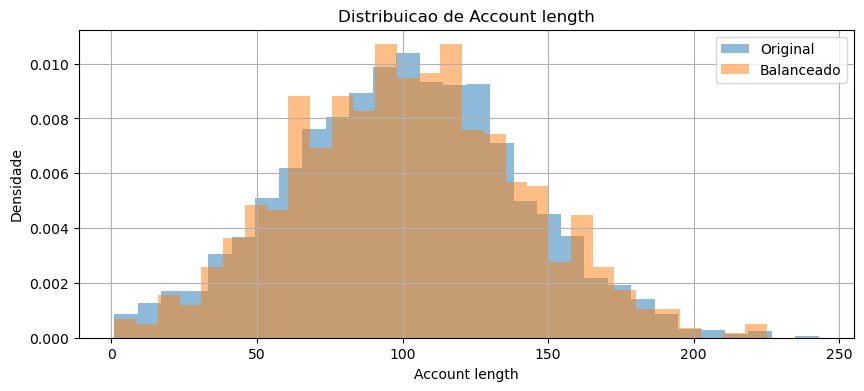

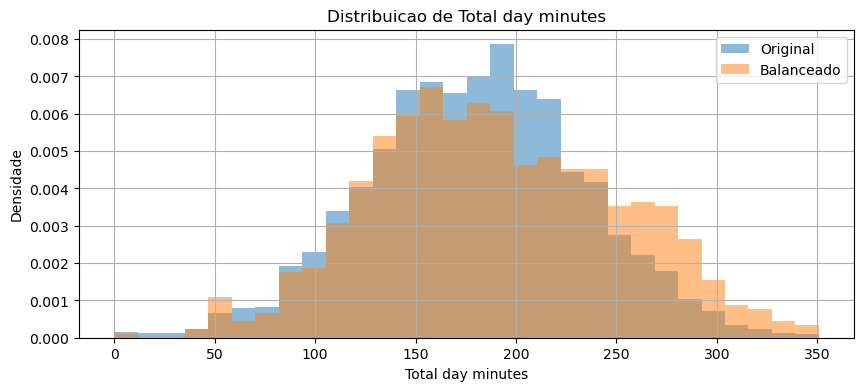

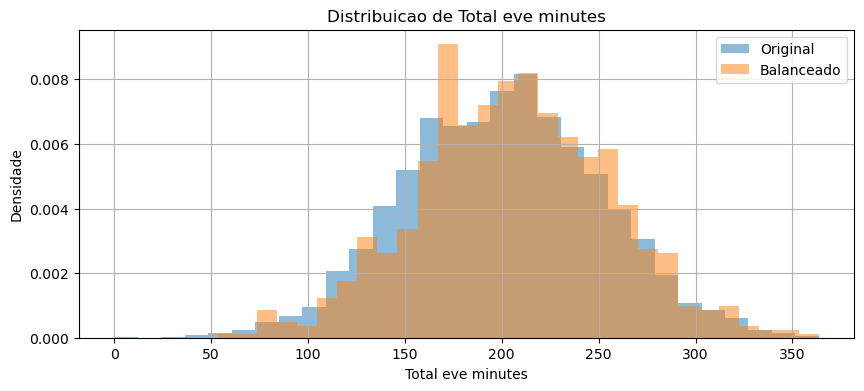

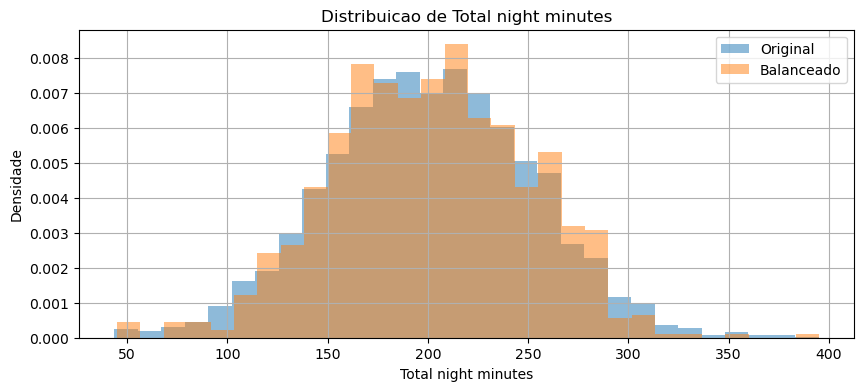

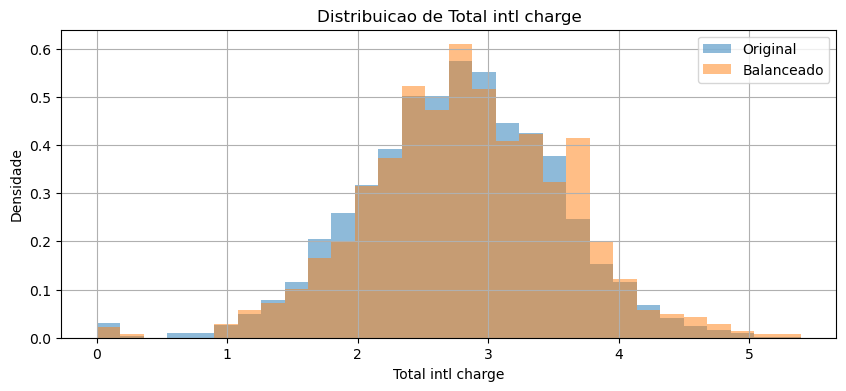

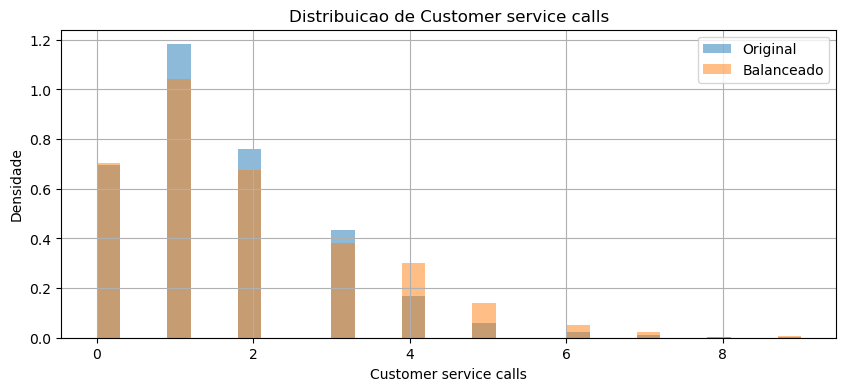

In [58]:
"""print(df_modelo.describe())
print(df_balanceado.describe())"""

variables = ["Account length",  "Total day minutes", "Total eve minutes",  "Total night minutes", "Total intl charge", "Customer service calls"]

for var in variables:
    plt.figure(figsize=(10,4))
    plt.hist(df_modelo[var], bins=30, alpha=0.5, label="Original",density=True)
    plt.hist(df_balanceado[var], bins=30, alpha=0.5, label="Balanceado", density=True)
    plt.title(f'Distribuicao de {var}')
    plt.xlabel(var)
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


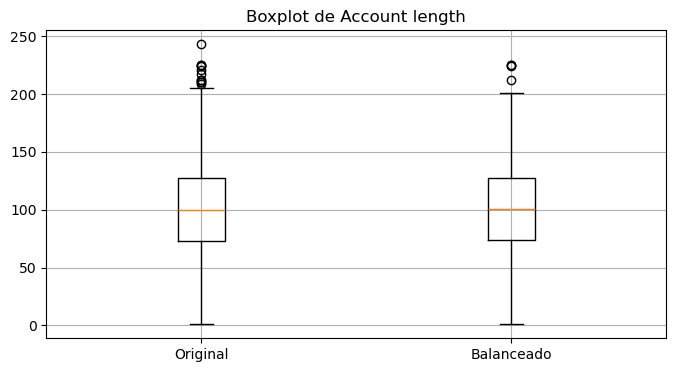

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


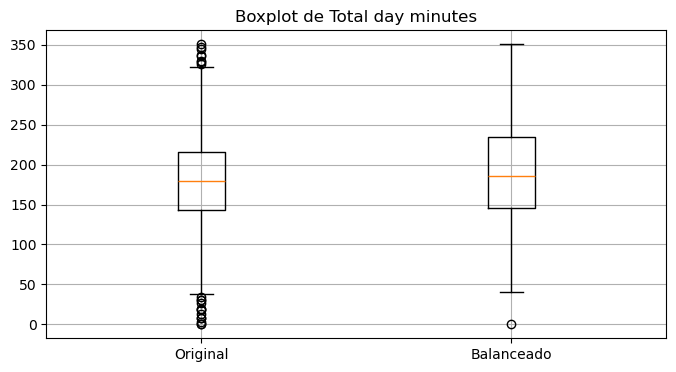

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


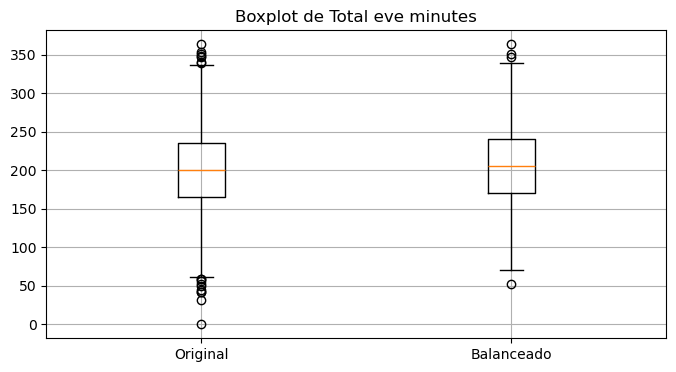

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


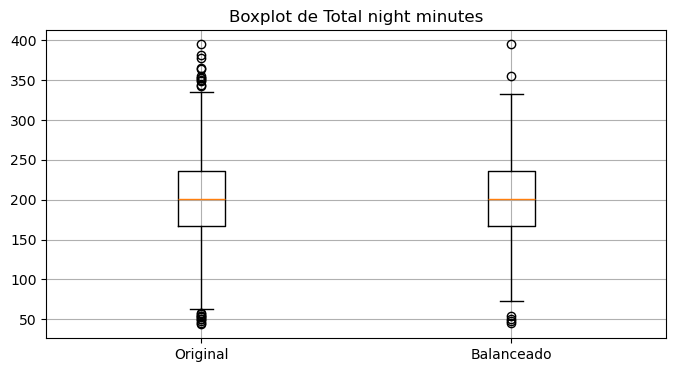

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


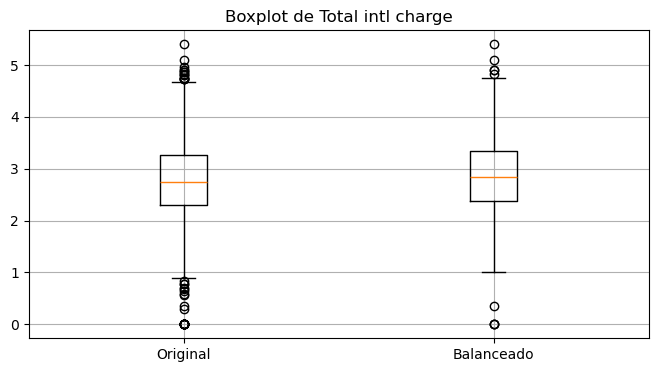

C:\Users\jfaze\AppData\Local\Temp\ipykernel_25868\1599694878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])


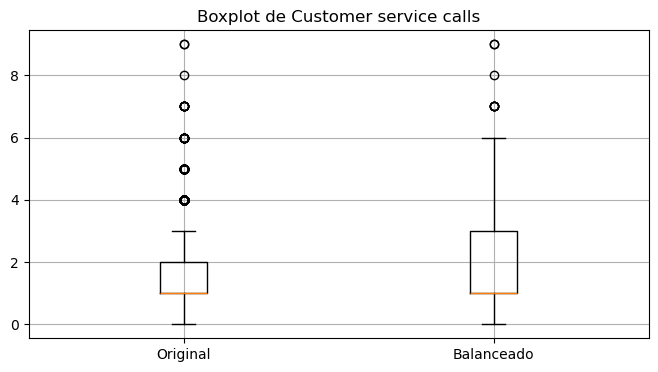

In [59]:
for var in variables:
    data_original = df_modelo[var].dropna()
    data_balanceado = df_balanceado[var].dropna()

    plt.figure(figsize=(8, 4))
    plt.boxplot([data_original, data_balanceado], labels=["Original", "Balanceado"])
    plt.title(f"Boxplot de {var}")
    plt.grid(True)
    plt.show()

### Depois de haver reduzido tenho que criar as variaves testes e objetivo, treinar o modelo novamente e sacar a matriz confusion e o reporte de classificacao

In [64]:
X_balanceado = df_balanceado.drop("Churn_int", axis=1)
y_balanceado = df_balanceado["Churn_int"]

In [66]:
# Treino e teste
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split (X_balanceado, y_balanceado, test_size = 0.2, random_state=777, stratify=y_balanceado)

modelo_rf.fit(X_train_final,y_train_final)

RandomForestClassifier(n_jobs=-1, random_state=777)

In [68]:
# Prediction
y_pred_final = modelo_rf.predict(X_test_final)

In [70]:
print("Matriz de confusión:")
print(confusion_matrix(y_test_final, y_pred_final))

print("\nReporte de clasificación:")
print(classification_report(y_test_final, y_pred_final, digits=4))

Matriz de confusión:
[[66 12]
 [10 68]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8684    0.8462    0.8571        78
           1     0.8500    0.8718    0.8608        78

    accuracy                         0.8590       156
   macro avg     0.8592    0.8590    0.8590       156
weighted avg     0.8592    0.8590    0.8590       156



In [238]:
### Se pode notar uma melhora muito grande, 85% de precisao e 87% de recall. Antes era 84% de presicao e 74% de recall

### Agora usar o csv_20 para um teste real

In [74]:
y_predi_final = modelo_rf.predict(X_test_real)

In [76]:
print("Matriz de confusión:")
print(confusion_matrix(y_test_real, y_predi_final))

print("\nReporte de clasificación:")
print(classification_report(y_test_real, y_predi_final))

Matriz de confusión:
[[463 109]
 [ 11  84]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       572
           1       0.44      0.88      0.58        95

    accuracy                           0.82       667
   macro avg       0.71      0.85      0.73       667
weighted avg       0.90      0.82      0.84       667



In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)